## Notebook for hyperparameter-tuning for TimeGAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from models.data_generating_models.quant_gan import QuantGAN
from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config
from models.DeepHedger import hedging
from config import data_generation_config
import wandb

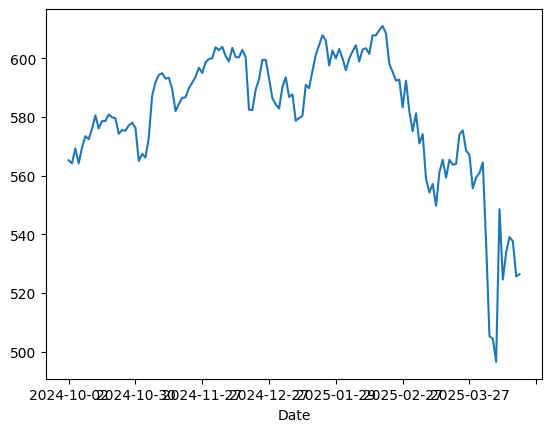

In [2]:
train_data = pd.read_csv("../data/raw/spy_daily_closing_prices_train.csv", index_col=0)

val_data = pd.read_csv("../data/raw/spy_daily_closing_prices_val.csv", index_col=0)

val_data = val_data["Close"]
val_data.plot(use_index=True)
val_data = np.array([val_data.values[i:i+30] for i in range(len(val_data)-30 + 1)])
val_data = pd.DataFrame(val_data)
val_data = val_data.div(val_data.iloc[:, 0], axis=0)

In [3]:
wandb.login(key="52ea61320bbc9ee2b773e909700366e65977cd0f")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sarogde (sarogde-ntnu). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/sondrerogde/.netrc


True

In [4]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.00002,
            'max': 0.002
        },
        'batch_size': {
            'values': [16, 32, 64, 128]
        },
        'clip_value': {
            'distribution': 'uniform',
            'min': 0.001,
            'max': 0.1
        },
    }
}

In [5]:
sweep_id = wandb.sweep(sweep_config, project="quant_gan_hyperopt")
# sweep_id = "ugr4esop"

Create sweep with ID: v6b1e9lp
Sweep URL: https://wandb.ai/sarogde-ntnu/quant_gan_hyperopt/sweeps/v6b1e9lp


In [6]:
def objective(config):
    hyperparameters = {
        "clip_value": config.clip_value,
        "lr": config.learning_rate,
        "num_epochs": 15,
        "nz": 3,
        "batch_size": config.batch_size,
        "seq_len": 30,
    }


    print('Training data generating model')
    model = QuantGAN(train_data, data_generation_config['N'], data_generation_config['M'], load_params=False, config=hyperparameters)
    model.fit_params_to_data()

    print('Generating data...')
    model.generate_data()

    df = 1*np.exp(model.synth_data)

    df_post_processed = post_processing(df, **post_processing_config)

    print('Hedging')
    val_loss = hedging(df_post_processed, val_data)

    return val_loss

def main():
    wandb.init()
    val_loss = objective(wandb.config)
    wandb.log({"val_loss": val_loss,  "loss": val_loss})

In [ ]:
wandb.agent(sweep_id, function=main, count=30, project="quant_gan_hyperopt")

## Manual tuning

In [9]:
hyperparameters = {
    "clip_value": 0.04846214746770365, #0.01 default
    "lr": 0.0011239390884900244, # 0.0002 default
    "num_epochs": 10,
    "nz": 3,
    "batch_size": 64,
    "seq_len": 30,
}

model = QuantGAN(train_data, 30, 2000, load_params=False, config=hyperparameters)
model.fit_params_to_data()

model.generate_data()
df = 1*np.exp(model.synth_data)

df_post_processed = post_processing(df, **post_processing_config)


Loss_D: 0.00000042 Loss_G: -1.00000000: 100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


In [10]:
print(model.synth_data.shape)

(2000, 30)


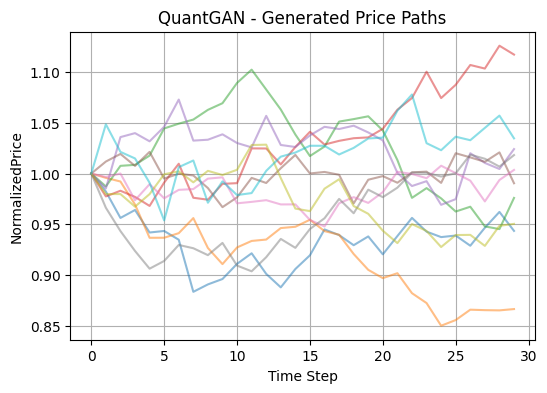

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

# Plot post-processed paths
for i in range(10):
    axs.plot(df_post_processed.iloc[i, :], alpha=0.5)
#     axs[1].plot(model.synth_data.iloc[i, :], alpha=0.5)
#     axs[2].plot(model.X[i, :], alpha=0.5)


axs.set_title('QuantGAN - Generated Price Paths')
axs.set_xlabel('Time Step')
axs.set_ylabel('NormalizedPrice')
axs.grid(True)

In [16]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualization(ori_data, generated_data, analysis, data_generating_model, compare=3000):
    """Using PCA or tSNE for generated and original data visualization.
  
  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca or kernel
  """
    # Analysis sample size (for faster computation)
    anal_sample_no = min([compare, ori_data.shape[0]])
    idx = np.random.permutation(ori_data.shape[0])[:anal_sample_no]

    # Data preprocessing
    # ori_data = np.asarray(ori_data)
    # generated_data = np.asarray(generated_data)

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    no, seq_len, dim = ori_data.shape

    for i in range(anal_sample_no):
        if (i == 0):
            prep_data = np.reshape(np.mean(ori_data[0, :, :], 1), [1, seq_len])
            prep_data_hat = np.reshape(np.mean(generated_data[0, :, :], 1), [1, seq_len])
        else:
            prep_data = np.concatenate((prep_data,
                                        np.reshape(np.mean(ori_data[i, :, :], 1), [1, seq_len])))
            prep_data_hat = np.concatenate((prep_data_hat,
                                            np.reshape(np.mean(generated_data[i, :, :], 1), [1, seq_len])))

    # Visualization parameter
    colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]

    if analysis == 'pca':
        # PCA Analysis
        pca = PCA(n_components=2)
        pca.fit(prep_data)
        pca_results = pca.transform(prep_data)
        pca_hat_results = pca.transform(prep_data_hat)

        # Plotting
        f, ax = plt.subplots(1)
        plt.scatter(pca_results[:, 0], pca_results[:, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(pca_hat_results[:, 0], pca_hat_results[:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")

        ax.legend()
        plt.title(f'PCA plot for {data_generating_model}')
        plt.xlabel('x-pca')
        plt.ylabel('y-pca')
        plt.show()

    elif analysis == 'tsne':

        # Do t-SNE Analysis together
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)

        # TSNE anlaysis
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(prep_data_final)

        # Plotting
        f, ax = plt.subplots(1)

        plt.scatter(tsne_results[:anal_sample_no, 0], tsne_results[:anal_sample_no, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(tsne_results[anal_sample_no:, 0], tsne_results[anal_sample_no:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")

        ax.legend()

        plt.title(f't-SNE plot for {data_generating_model}')
        plt.xlabel('x-tsne')
        plt.ylabel('y-tsne')
        plt.show()

    elif analysis == 'kernel':
       
        # Visualization parameter
        # colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]

        f, ax = plt.subplots(1)
        sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
        sns.distplot(prep_data_hat, hist=False, kde=True, kde_kws={'linewidth': 5, 'linestyle':'--'}, label='Synthetic', color="blue")
        # Plot formatting

        # plt.legend(prop={'size': 22})
        plt.legend()
        plt.xlabel('Data Value')
        plt.ylabel('Data Density Estimate')
        # plt.rcParams['pdf.fonttype'] = 42

        # plt.savefig(str(args.save_dir)+"/"+args.model1+"_histo.png", dpi=100,bbox_inches='tight')
        # plt.ylim((0, 12))
        plt.show()
        plt.close()

(1060, 30, 1)
(2000, 30, 1)


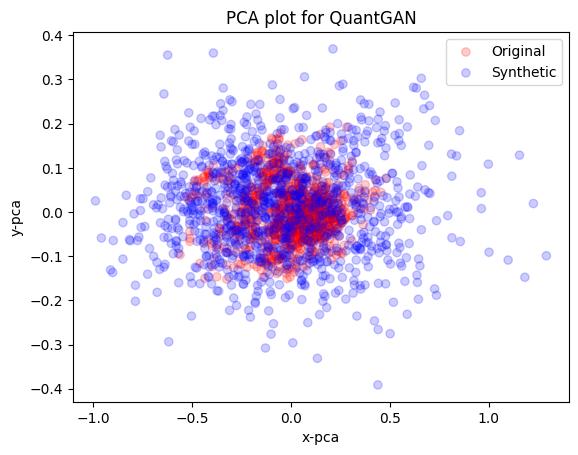

In [19]:
train_data_vis = np.array(train_data[["Close"]].values)
train_data_vis = np.array([train_data_vis[i:i+30] for i in range(len(train_data_vis)-30 + 1)])
train_data_vis = train_data_vis / train_data_vis[:, 0:1]

df_post_processed_vis = np.array(df_post_processed.values)
df_post_processed_vis = df_post_processed_vis[..., np.newaxis]

print(train_data_vis.shape)
print(df_post_processed_vis.shape)

visualization(ori_data=train_data_vis, generated_data=df_post_processed_vis, analysis='pca', data_generating_model="QuantGAN", compare=train_data_vis.shape[0])